# Calculations for Sensor Calibration

Import standard data analysis, numerical comutation, and plotting libraries.

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

Import the data.

In [4]:
df = pd.read_csv('data.csv', header=0)
df.columns = ['position', 'voltage']

Make a quick plot.

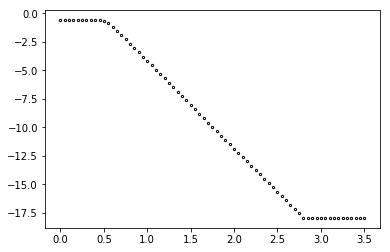

In [7]:
plt.scatter(df['position'], df['voltage'], s=5, c='w', edgecolor='k')
plt.show()

The __linear region__ appears to exten from 0.75 mm to 2.50 mm. We can get the exact bounds latter, but for now, lets just fit a linear calibration curve.

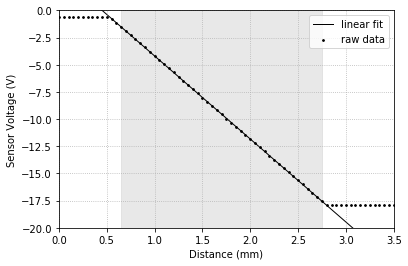

(-7.636933797909405, 3.442299651567946)

In [32]:
lb, ub = 0.65, 2.75

lr = df[(df['position'] > lb) & (df['position'] < ub)]

m, b = np.polyfit(lr['position'], lr['voltage'], 1)

x = np.linspace(lb - 0.5, ub + 0.5, 1000)

plt.scatter(df['position'], df['voltage'], s=3, c='k', label='raw data', zorder=2)
plt.plot(x, m * x + b, linewidth=1, color='black', linestyle='-', label='linear fit', zorder=1)
plt.axvspan(lb, ub, alpha=0.5, color='lightgrey', zorder=0)

plt.legend(loc='upper right')
plt.ylabel('Sensor Voltage (V)')
plt.xlabel('Distance (mm)')
plt.ylim((-20, 0))
plt.xlim((0, 3.5))
plt.grid(linestyle=':')

plt.savefig('linear', dpi=300)
plt.show()

m, b

Lets plot the residuals to get a better idea of how well our model fits.

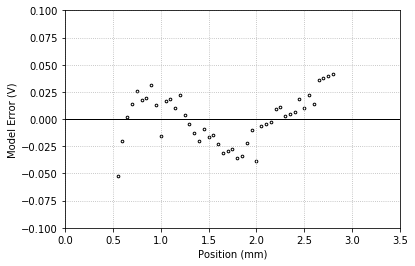

In [14]:
r = df['voltage'] - (m * df['position'] + b)

plt.scatter(df['position'], r, c='w', edgecolor='k', s=7)
plt.axhline(0, color='black', linewidth=1)

plt.grid(linestyle=':')

pm = 0.1
plt.ylim((-pm, pm))
plt.xlim((0, 3.5))

plt.ylabel('Model Error (V)')
plt.xlabel('Position (mm)')


plt.show()

The residuals do not appear to be normally distributed, let's try a couple polynomial fits.

from scipy.stats import norm

lb, ub = 0.70, 2.75
lr = df[(df['position'] > lb) & (df['position'] < ub)]

n = 5

fig, axes = plt.subplots(3, n, figsize=(4 * n, 10))

for i in range(n):
    f = np.poly1d(np.polyfit(lr['position'], lr['voltage'], i+1))
    x = np.linspace(lb - 0.5, ub + 0.5, 1000)

    axes[0, i].scatter(df['position'], df['voltage'], s=3, color='black', label='raw', zorder=2)
    axes[0, i].plot(x, f(x), linewidth=0.75, color='black', linestyle='-',label='fit', zorder=1)
    axes[0, i].axvspan(lb, ub, alpha=0.5, color='lightgrey', zorder=0)

    axes[0, i].set_ylim((-20, 0))
    axes[0, i].set_xlim((0, 3.5))
    axes[0, i].set_xlabel('Target Distance (mm)')
    axes[0, i].grid(linestyle=':')

    
    r = df['voltage'] - f(df['position'])

    axes[1, i].scatter(df['position'], r * 1000, color='black', s=3)
    axes[1, i].axhline(0, color='black', linewidth=1)
    axes[1, i].axvspan(lb, ub, alpha=0.5, color='lightgrey', zorder=0)

    axes[1, i].grid(linestyle=':')
    axes[1, i].set_xlabel('Target Distance (mm)')

    pm = 50
    axes[1, i].set_ylim((-pm, pm))
    axes[1, i].set_xlim((0, 3.5))

    hist_min, hist_max = -50, 50
    x = np.linspace(hist_min, hist_max, 1000)
    r_lr = r[(df['position'] > lb) & (df['position'] < ub)] * 1000
    
    axes[2, i].hist(r_lr, color='lightyellow', edgecolor='black', normed=True)
    axes[2, i].plot(x, norm.pdf(x, loc=r_lr.mean(), scale=r_lr.std()), color='k', linewidth=2)
    axes[2, i].set_xlim((hist_min, hist_max))
    axes[2, i].set_ylim((0, 0.05))
    axes[2, i].set_xlabel('Polynomial Fit Residuals (mV)')
    
axes[0, 0].set_ylabel('Sensor Voltage (V)')
axes[1, 0].set_ylabel('Poloynomial Fit Residuals (mV)')
axes[2, 0].set_ylabel('Frequency, $f$')

fig.savefig('all_fits', dpi=300)
fig.show()

The quartic fit seems to be the lowest order polynomial fit that produces normally distributed residuals. We can find the parameters for that fit using `np.polyfit` again.

In [21]:
c = np.polyfit(lr['voltage'], lr['position'], 1)
f = np.poly1d(c)

r = f(lr['voltage']) - lr['position']
r = np.abs(r)

r.mean()

0.0022994585054155045

Lets determine the 2D Chauvenet's deviation for the fit.

$$
    \sigma _d = \sqrt{ \frac{\sum (\delta_i)^2}{(n-1)}}
$$

In [22]:
def sigma_d(x):
    x = np.asarray(x)
    
    n = x.size
    return np.sqrt((x * x).sum() / (n - 1))

Let's calculate the sample standard deviation.

In [23]:
sigma_d(r)

0.002700640429142679

We can then look up the critical deviation ratio based on sample size.

In [24]:
r.size

41

The critical deviation ratio is __2.98__, and we check for any samples that exceed the deviation ratio.

In [25]:
r[r / sigma_d(r) > 2.98]

Series([], Name: position, dtype: float64)

None are found.

Now we can use the Student's t distribution to determine the 90% confidence interval of the quartic fit. The inteval is determined as follows.

$$
    V = C_4 x^4 + C_3 x^3 + C_2 x2 + C_1 x + C_0 \pm t(\alpha, \nu)\sigma_d
$$

The t value is.

In [26]:
from scipy.stats import t

alpha = 0.95
v = r.size - 2

t.ppf(alpha, df=v)

1.6848751194973992

This leads to a fitting uncertainty of

In [27]:
CI = t.ppf(alpha, df=v) * sigma_d(r)

This can be plotted over the quartic fit.

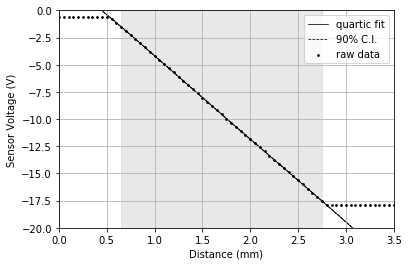

-0.066
0.471
-1.139
-6.559
3.115


In [40]:
lb, ub = 0.65, 2.75

lr = df[(df['position'] > lb) & (df['position'] < ub)]

C = np.polyfit(lr['position'], lr['voltage'], 4)
f = np.poly1d(C)

x = np.linspace(lb - 0.5, ub + 0.5, 1000)

plt.scatter(df['position'], df['voltage'], s=3, color='black', label='raw data', zorder=2)
plt.plot(x, f(x), linewidth=0.75, color='black', linestyle='-', label='quartic fit', zorder=1)
plt.plot(x, f(x) + CI, linewidth=0.75, color='black', linestyle='--', zorder=1, label='90% C.I.')
plt.plot(x, f(x) - CI, linewidth=0.75, color='black', linestyle='--', zorder=1)
plt.axvspan(lb, ub, alpha=0.5, color='lightgrey', zorder=0)

plt.legend(loc='upper right')
plt.ylabel('Sensor Voltage (V)')
plt.xlabel('Distance (mm)')
plt.ylim((-20, 0))
plt.xlim((0, 3.5))
plt.grid()

plt.savefig('quartic', dpi=300)
plt.show()

for i in C:
    print('{i:.3f}'.format(i=i))

In [34]:
np.__version__

'1.14.2'